In [3]:
from gpt3forchem.data import get_polymer_data
from gpt3forchem.input import create_single_property_inverse_polymer_prompts
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_regression_prediction, extract_inverse_prediction

from gpt3forchem.output import polymer_string2performance

import matplotlib.pyplot as plt

import time

import pandas as pd 

In [4]:
df = get_polymer_data()

In [5]:
df['deltaGmin_rounded'] = df['deltaGmin'].round(2)

In [6]:
prompts = create_single_property_inverse_polymer_prompts(df, 'deltaGmin_rounded', {'deltaGmin_rounded': 'adsorption energy'}, encode_value=False)

In [7]:
prompts['target'] = df['deltaGmin_rounded']

(array([ 26., 148., 299., 490., 592., 575., 499., 326., 141.,  29.]),
 array([-20.67 , -18.907, -17.144, -15.381, -13.618, -11.855, -10.092,
         -8.329,  -6.566,  -4.803,  -3.04 ]),
 <BarContainer object of 10 artists>)

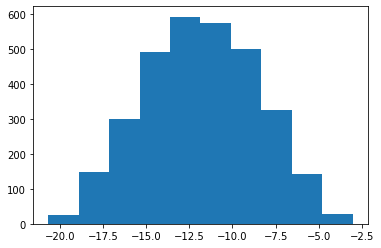

In [8]:
plt.hist(df['deltaGmin_rounded'])

In [9]:
df_train = prompts[prompts['target'] < -7.5]
df_test = prompts[prompts['target'] >= -7.5]

In [10]:
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_mof_h2o.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_mof_h2o.jsonl"

df_train.to_json(train_filename, orient="records", lines=True)
df_test.to_json(valid_filename, orient="records", lines=True)


In [11]:
fine_tune(train_filename, valid_filename, "ada")

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-11-21-22-47-49'

In [12]:
completions_0 = query_gpt3('ada:ft-lsmoepfl-2022-11-21-22-47-49', df_test, max_tokens=300, temperature=0)
completions_05 = query_gpt3('ada:ft-lsmoepfl-2022-11-21-22-47-49', df_test, max_tokens=300, temperature=0.5)
completions_1 = query_gpt3('ada:ft-lsmoepfl-2022-11-21-22-47-49', df_test, max_tokens=300, temperature=1.0)
completions_15 = query_gpt3('ada:ft-lsmoepfl-2022-11-21-22-47-49', df_test, max_tokens=300, temperature=1.5)

In [16]:
preds_0 = [extract_inverse_prediction(completions_0, i) for i, completion in enumerate(completions_0['choices'])]  
preds_05 = [extract_inverse_prediction(completions_05, i) for i, completion in enumerate(completions_05['choices'])]   
preds_1 = [extract_inverse_prediction(completions_1, i) for i, completion in enumerate(completions_1['choices'])]   
preds_15 = [extract_inverse_prediction(completions_15, i) for i, completion in enumerate(completions_15['choices'])]   

In [18]:
predictions_0 = [polymer_string2performance(pred)['prediction'][0] for pred in preds_0]
predictions_05 = [polymer_string2performance(pred)['prediction'][0] for pred in preds_05]
predictions_1 = []
for pred in preds_1:
    try:
        predictions_1.append(polymer_string2performance(pred)['prediction'][0])
    except:
        pass

predictions_15 = []
for pred in preds_15:
    try: 
        predictions_15.appemd(polymer_string2performance(pred)['prediction'][0])
    except Exception: 
        pass 

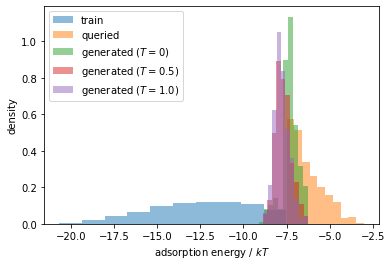

In [26]:
plt.hist(df_train['target'], alpha=0.5, label='train', density=True)
plt.hist(df_test['target'], alpha=0.5, density=True, label='queried')
plt.hist(predictions_0, alpha=0.5, density=True, label='generated ($T=0$)')
plt.hist(predictions_05, alpha=0.5, density=True, label='generated ($T=0.5$)')
plt.hist(predictions_1, alpha=0.5, density=True, label='generated ($T=1.0$)')
#plt.hist(predictions_15, alpha=0.5, density=True, label='generated ($T=1.5$)')
plt.legend()
plt.xlabel('adsorption energy / $kT$')
plt.ylabel('density')
plt.savefig('ads_energy_dist.pdf', bbox_inches='tight')

# Now do query specifycally very low ones 

In [27]:
df_test_small = df_test.copy()

In [28]:
df_test_small.prompt.iloc[0].split('adsorption energy and')

['what is a polymer with -7.27 ', ' 4 A, 4 B, 4 W, and 4 R?###']

In [43]:
prompts = []

for i, row in df_test_small.iterrows():
    composition = row.prompt.split('adsorption energy and')[1]
    new_prompt = "what is a polymer with adsorption energy larger than -2.0 and " + composition
    prompts.append(new_prompt)

In [44]:
new_test_frame = pd.DataFrame({'prompt': list(set(prompts)), 'completion': ['']*len(set(prompts))})

In [45]:
completions_very_low = query_gpt3('ada:ft-lsmoepfl-2022-11-18-17-03-36', new_test_frame, max_tokens=300)

In [46]:
preds_very_low = [extract_inverse_prediction(completions_very_low, i) for i in range(len(completions_very_low['choices'])) ]   

In [48]:
predictions_very_low = []

for pred in preds_very_low:
    try:
        predictions_very_low.append(polymer_string2performance(pred)['prediction'][0])
    except Exception:
        pass

(array([ 1.,  3.,  6.,  7., 14., 21., 29.,  6.,  5.,  4.]),
 array([-8.699791 , -8.458611 , -8.217431 , -7.9762506, -7.73507  ,
        -7.4938903, -7.2527103, -7.01153  , -6.77035  , -6.5291696,
        -6.2879896], dtype=float32),
 <BarContainer object of 10 artists>)

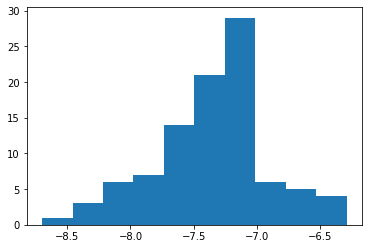

In [49]:
plt.hist(predictions_very_low)